# **Home Depot Product Search Relevance**
##Practical Deep Learning Workshop 2021- Character level LSTM
###Inbal Biton, Shachar Meretz

For this assigment we use kaggle dataeset - Home Depot Product Search Relevance


(https://www.kaggle.com/c/home-depot-product-search-relevance)

In this task we received a dataset containing information on query that users search and product description for each product in the website. In this task we Predict the relevance of search results on homedepot.com. For this purpose we will use regression models

# **Task 2 - Word Embeddings and Word Level LSTM**



Our task in this section is to predict the relevance of a particular search terms according to the product description - but in this section we will perform the word-level prediction. 

During this part we will create a dictionary according to the tokens we will receive when we process the data. Our dictionary will contain a number of unique tokens. From these tokens we will create a word2vec model to represent each word in the search term as well as each word in the product description we have. 

We will perform embedding process using the word2vec model for the words and create a Siamese model to predict the relevance - we will insert 2 inputs into the model: 

* The first input layer refers to the query itself - from the column "Search Terms" 
* The second input layer refers to the description of the product we intended - from the column "Product Description"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Imports**

In [1]:
import os
import pandas as pd
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score ,mean_absolute_error , mean_squared_error
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dot, BatchNormalization, Dropout, Lambda, Multiply, Concatenate
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed

import gensim 
from gensim import corpora
from collections import defaultdict
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
Main_dir = r'/content/drive/MyDrive/Ass3'

## **Preprocess The Data To Create Tokens Of Words**

In [ ]:
def Load_Data(Main_dir):
    attributes_df = pd.read_csv(os.path.join(Main_dir,'attributes.csv'),engine='python')
    prod_desc_df = pd.read_csv(os.path.join(Main_dir,'product_descriptions.csv'),engine='python')
    train_df = pd.read_csv(os.path.join(Main_dir,'train.csv'),engine='python')
    test_df = pd.read_csv(os.path.join(Main_dir,'test.csv'),engine='python')
    train_df = train_df.merge(prod_desc_df, on='product_uid', how='left').drop(['product_title'], axis=1)
    test_df = test_df.merge(prod_desc_df, on='product_uid', how='left').drop(['product_title'], axis=1)
    return train_df, test_df , attributes_df


In [ ]:
Train , Test , Att_df = Load_Data(Main_dir)
Train.shape , Test.shape

((74067, 5), (166693, 4))

### **Check For Missing Values**

In [ ]:
Train.isna().sum()

id                     0
product_uid            0
search_term            0
relevance              0
product_description    0
dtype: int64

In [ ]:
Test.isna().sum()

id                     0
product_uid            0
search_term            0
product_description    0
dtype: int64

In [ ]:
Train.head()

,id,product_uid,search_term,relevance,product_description
0,2,100001,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [ ]:
Test.head()

,id,product_uid,search_term,product_description
0,1,100001,90 degree bracket,"Not only do angles make joints stronger, they ..."
1,4,100001,metal l brackets,"Not only do angles make joints stronger, they ..."
2,5,100001,simpson sku able,"Not only do angles make joints stronger, they ..."
3,6,100001,simpson strong ties,"Not only do angles make joints stronger, they ..."
4,7,100001,simpson strong tie hcc668,"Not only do angles make joints stronger, they ..."


## **Convert Words To Tokens**

We will creates tokens by spliting the phrases to single words. the spliting will be doing by the punctional - '**,**' , '**.**' , '**:**' , '**;**' , '**\n**' , '**\t**'

In [ ]:
def replace_chars(word):
    chars = ['\n','\t','.',',',':',';']
    for c in chars:
        word = word.replace(c,' ')
    return word.lower()

def Text_To_Tokens(df):
    stoplist = set('for a of the and to in'.split())
    search_terms = list(df['search_term'])
    df['search_term'] = [[word for word in replace_chars(phrase).split(' ') if word not in stoplist] for phrase in df['search_term']]

    search_desc = list(df['product_description'])
    df['product_description'] = [[word for word in replace_chars(desc).split(' ') if word not in stoplist] for desc in df['product_description']]
    return df

In [ ]:
train_df = Text_To_Tokens(Train.copy())
test_df = Text_To_Tokens(Test.copy())

In the next step we will concatenates all the phrases from the main 2 columns - **"search_term"** and **"product_description"** 

This list of tokens will be the basis for building our dictionary according to which we will train the model and make a prediction for the **Test Set**

In [ ]:
texts = np.concatenate([np.array(train_df['search_term']),
                       np.array(train_df['product_description'])])
texts.shape

(148134,)

To find the right embadding size for token, we will use the tools of "genism" to build a dictionary and to know how many unique tokens we have in the corpus, Filter tokens that only appear once - these tokens probably only appeared in one column so they will not donate to us.

In [ ]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]


In [ ]:
dictionary = corpora.Dictionary(texts)
dictionary.save('doctionary.dict') 
print(dictionary)

2021-01-21 07:40:56,059 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-21 07:40:56,140 : INFO : adding document #10000 to Dictionary(4092 unique tokens: ['angle', 'bracket', 'l', 'deck', 'over']...)
2021-01-21 07:40:56,218 : INFO : adding document #20000 to Dictionary(5655 unique tokens: ['angle', 'bracket', 'l', 'deck', 'over']...)
2021-01-21 07:40:56,293 : INFO : adding document #30000 to Dictionary(6357 unique tokens: ['angle', 'bracket', 'l', 'deck', 'over']...)
2021-01-21 07:40:56,372 : INFO : adding document #40000 to Dictionary(6734 unique tokens: ['angle', 'bracket', 'l', 'deck', 'over']...)
2021-01-21 07:40:56,460 : INFO : adding document #50000 to Dictionary(7019 unique tokens: ['angle', 'bracket', 'l', 'deck', 'over']...)
2021-01-21 07:40:56,542 : INFO : adding document #60000 to Dictionary(7614 unique tokens: ['angle', 'bracket', 'l', 'deck', 'over']...)
2021-01-21 07:40:56,624 : INFO : adding document #70000 to Dictionary(7878 unique tokens: ['angle

Dictionary(121737 unique tokens: ['angle', 'bracket', 'l', 'deck', 'over']...)


We get that based on the training set we have **121,737** unique tokens, so our embadding size will be the root of this number and a division into 4 so that we get good performance when we use **gensim's word2vec model**

Embadding size - **352**

In [ ]:
Unique_Tokens = 121737#len(dictionary)
print("Unique Tokens , ",Unique_Tokens)
Embadding_size = np.sqrt(Unique_Tokens)
Embadding_size = int((Embadding_size-(Embadding_size%4)) + 4)
print("Embadding Size , ",Embadding_size)

Unique Tokens ,  121737
Embadding Size ,  352


## **Create Word2Vec Model For Embedding**

In [ ]:
import multiprocessing
from gensim.models import Word2Vec
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     size=Embadding_size,
                     workers=cores-1)

In [ ]:
w2v_model.build_vocab(texts, progress_per=10000)

2021-01-23 13:41:42,612 : INFO : collecting all words and their counts
2021-01-23 13:41:42,615 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-23 13:41:42,631 : INFO : PROGRESS: at sentence #10000, processed 28910 words, keeping 4092 word types
2021-01-23 13:41:42,649 : INFO : PROGRESS: at sentence #20000, processed 58715 words, keeping 5655 word types
2021-01-23 13:41:42,658 : INFO : PROGRESS: at sentence #30000, processed 88637 words, keeping 6357 word types
2021-01-23 13:41:42,669 : INFO : PROGRESS: at sentence #40000, processed 117826 words, keeping 6734 word types
2021-01-23 13:41:42,681 : INFO : PROGRESS: at sentence #50000, processed 147276 words, keeping 7019 word types
2021-01-23 13:41:42,693 : INFO : PROGRESS: at sentence #60000, processed 181154 words, keeping 7614 word types
2021-01-23 13:41:42,706 : INFO : PROGRESS: at sentence #70000, processed 217546 words, keeping 7878 word types
2021-01-23 13:41:42,859 : INFO : PROGRESS: at sentence #

In [ ]:
w2v_model.train(texts, total_examples=len(texts), epochs=10, report_delay=1)

2021-01-23 13:42:08,298 : INFO : training model with 1 workers on 121737 vocabulary and 352 features, using sg=0 hs=0 sample=0.001 negative=5 window=2
2021-01-23 13:42:09,335 : INFO : EPOCH 1 - PROGRESS: at 50.38% examples, 286501 words/s, in_qsize 1, out_qsize 0
2021-01-23 13:42:10,350 : INFO : EPOCH 1 - PROGRESS: at 52.15% examples, 299848 words/s, in_qsize 2, out_qsize 0
2021-01-23 13:42:11,353 : INFO : EPOCH 1 - PROGRESS: at 53.91% examples, 302241 words/s, in_qsize 2, out_qsize 0
2021-01-23 13:42:12,368 : INFO : EPOCH 1 - PROGRESS: at 55.69% examples, 302565 words/s, in_qsize 1, out_qsize 0
2021-01-23 13:42:13,382 : INFO : EPOCH 1 - PROGRESS: at 57.53% examples, 302604 words/s, in_qsize 1, out_qsize 0
2021-01-23 13:42:14,389 : INFO : EPOCH 1 - PROGRESS: at 59.32% examples, 301798 words/s, in_qsize 2, out_qsize 0
2021-01-23 13:42:15,392 : INFO : EPOCH 1 - PROGRESS: at 61.20% examples, 301403 words/s, in_qsize 2, out_qsize 0
2021-01-23 13:42:16,413 : INFO : EPOCH 1 - PROGRESS: at 63

(81271171, 93805700)

## **Vector Size**

Now we will have to decide what size of vector to put as input to the model - we want to set a fixed size for the vector size that represented the column **"Search Term"** and a fixed vector size that represents the column **"Product Description"**, so we will lose less information but get an efficient process and not overloaded with information

We will take a look of the histogram of the length for each type of columns

### **Search Term Vector Size**

#### **Train** 

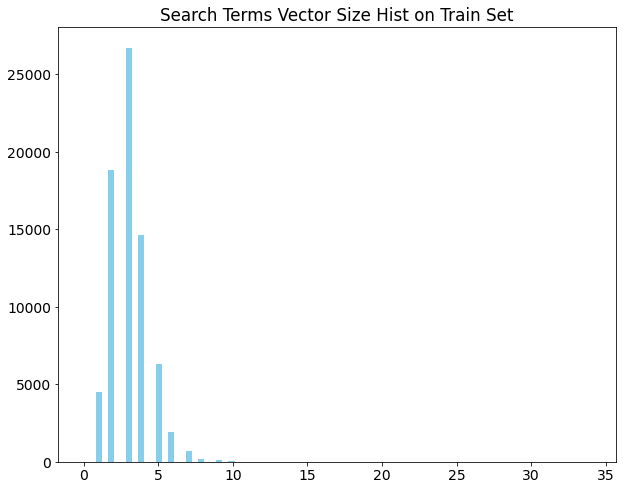

Mean Length Of Vector: 3


In [ ]:
vec_length_search_terms = [len(x) for x in train_df['search_term']]

plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(10,8)) 
plt.hist(vec_length_search_terms,bins="rice",color="skyblue",linewidth=3)
ax.set_title("Search Terms Vector Size Hist on Train Set")
#plt.xticks(rotation=45)

plt.show()

print("Mean Length Of Vector: {}".format(round(np.mean(vec_length_search_terms)),0))

#### **Test**

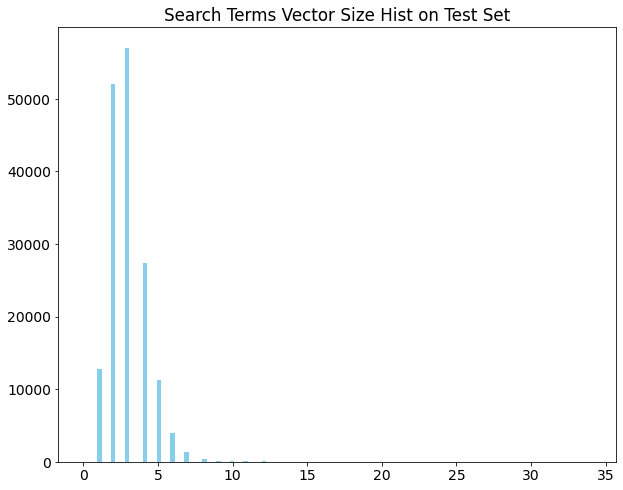

Mean Length Of Vector: 3


In [ ]:
vec_length_search_terms = [len(x) for x in test_df['search_term']]

plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(10,8)) 
plt.hist(vec_length_search_terms,bins="rice",color="skyblue",linewidth=3)
ax.set_title("Search Terms Vector Size Hist on Test Set")
#plt.xticks(rotation=45)

plt.show()

print("Mean Length Of Vector: {}".format(round(np.mean(vec_length_search_terms)),0))

We can choose the size of the vector to be **6** - in this size we will lose less information

### **Product Description Vector Size**

#### **Train**

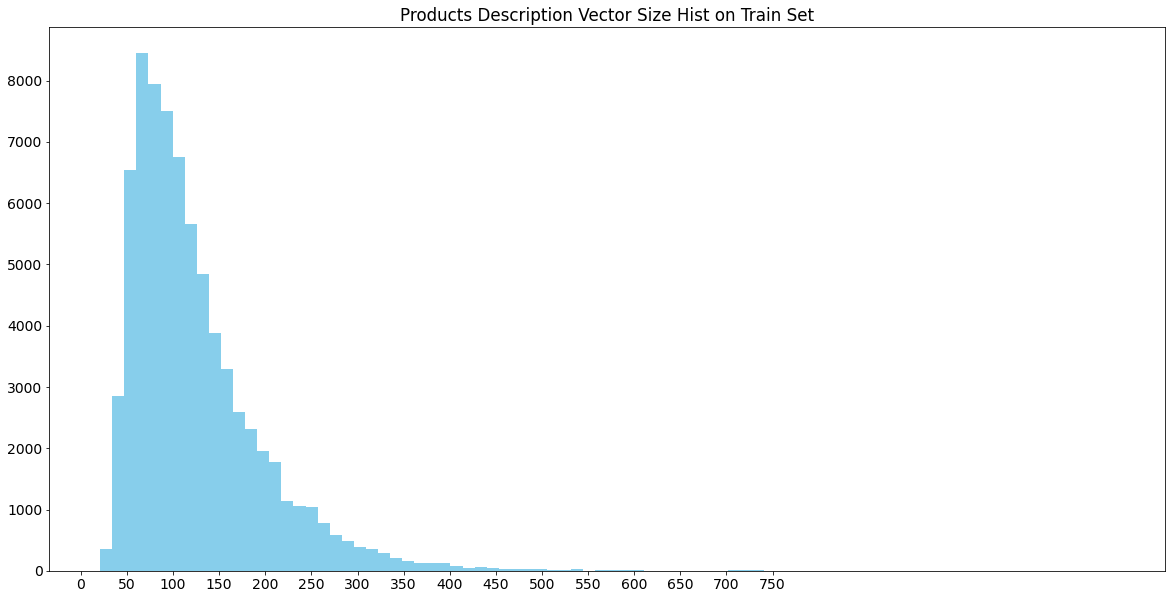

Mean Length Of Vector: 125


In [ ]:
vec_length_prods_descs = [len(x) for x in train_df['product_description']]

plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(20,10)) 
plt.hist(vec_length_prods_descs,bins="rice",color="skyblue",linewidth=3)
ax.set_title("Products Description Vector Size Hist on Train Set")
plt.xticks(np.arange(0,800,50))
#plt.xticks(rotation=45)

plt.show()

print("Mean Length Of Vector: {}".format(round(np.mean(vec_length_prods_descs)),0))

#### **Test**

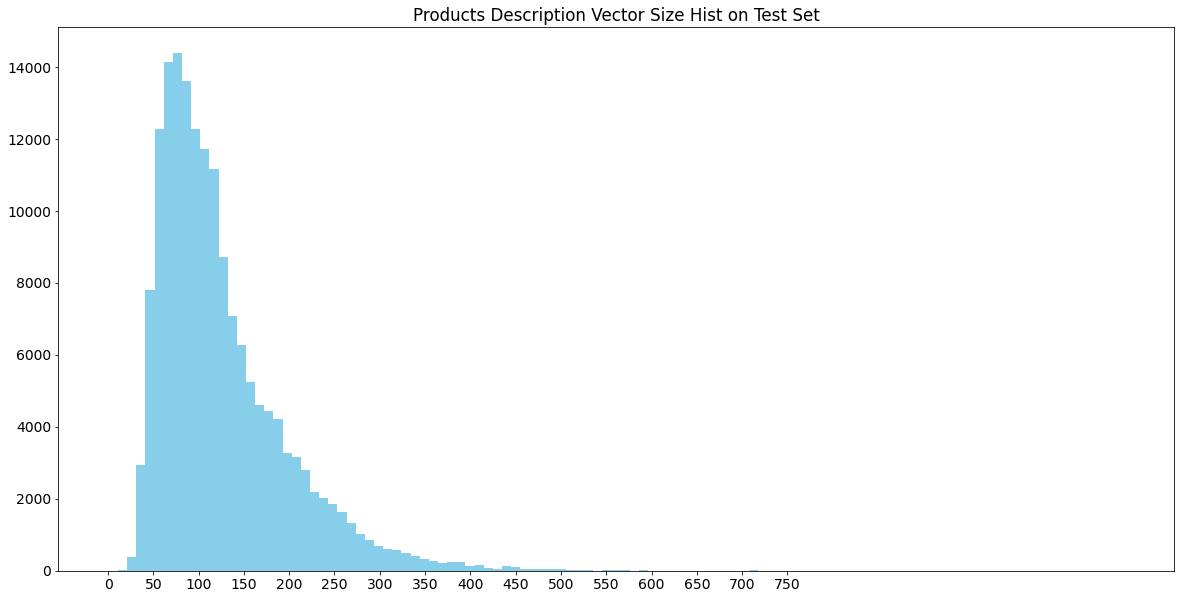

Mean Length Of Vector: 125


In [ ]:
vec_length_prods_descs = [len(x) for x in test_df['product_description']]

plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(20,10)) 
plt.hist(vec_length_prods_descs,bins="rice",color="skyblue",linewidth=3)
ax.set_title("Products Description Vector Size Hist on Test Set")
plt.xticks(np.arange(0,800,50))
#plt.xticks(rotation=45)

plt.show()

print("Mean Length Of Vector: {}".format(round(np.mean(vec_length_prods_descs)),0))

In [ ]:
search_term_vec_size = 6
prod_desc_vec_size = 350

We can choose the size of the vector to be **350** - in this size we will lose less information

## **Adjust vectors to selected sizes**

In order not to overload the RAM, we will use DataGenerator that yiels, for each record in the training set 2 tensors that will be input to our Siamese model:

* **Tensor 1** - Represents the column **"Search Term" : Shape  (1,6,352)**
* **Tensor 2** - Represents the column **""Prosuct Description" : Shape  (1,350,352)**

In [ ]:
def Embadding_Vectors_Generator(Embadding_size,w2v_model,df,epochs,max_len_st,max_len_pd,test=False):
    inx_st = df.columns.get_loc("search_term")
    inx_pd = df.columns.get_loc("product_description")
    inx_rel = df.columns.get_loc("relevance") if not test else -1
    for epoch in range(epochs):
        for i in range(len(df)):
            doc_pd = df.iloc[i,inx_pd]
            doc_st = df.iloc[i,inx_st]
            y = np.expand_dims(np.array(df.iloc[i,inx_rel]),axis=0) if not test else np.expand_dims(np.array(-1),axis=0)

            prd = [w2v_model.wv.get_vector(token) if token in w2v_model.wv.vocab else np.zeros(Embadding_size) for token in doc_pd]
            new_prd = []
            for i in range(max_len_pd):
                if i in range(0,len(prd)):
                    new_prd.append(prd[i])
                else:
                    new_prd.append(np.zeros(Embadding_size))

            st = [w2v_model.wv.get_vector(token) if token in w2v_model.wv.vocab else np.zeros(Embadding_size) for token in doc_st]
            new_st = []
            for i in range(max_len_st):
                if i in range(0,len(st)):
                    new_st.append(st[i])
                else:
                    new_st.append(np.zeros(Embadding_size))
            
            x1 = np.expand_dims(np.array(new_st),axis=0)
            x2 = np.expand_dims(np.array(new_prd),axis=0)
            if test:
                yield [x1,x2]
            else:
                yield [x1,x2],y

## **Siamese Network Model**

Construct and train a Siamese network - the input to the network should be the words/character-combinations constructing the search phrase and the item description, and the output should be the predicted search relevance score

Our Siamese model will be based on an LSTM layer in addition to dense layers to create different features that will help us predict the relevance.

After we have transferred each type of input in the Siamese model, we will combine the outputs for a single tensor by using a Multiply layer and with another dense layer we will get the relevance.

The results of the model are measured using 3 metrics:

* **MSE** - Loss Function
* **RMSE**
* **MAE**



### **Train Model**

In [ ]:
def construct_siamese_network(n_factors=10):
    inp = Input(shape=(None,352), name="Input")
    x = LSTM(16 , name="LSTM")(inp)
    x = Dense(32, activation='relu', name="Dense_32")(x)
    x = Dense(64, activation='relu', name="Dense_64")(x)
    x = Dense(128, activation='relu', name="Dense_128")(x)
    model = Model(inputs=inp, outputs=x, name="Siamese_Model")
    return model

model = construct_siamese_network()
model.summary()

Model: "Siamese_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, None, 352)]       0         
_________________________________________________________________
LSTM (LSTM)                  (None, 16)                23616     
_________________________________________________________________
Dense_32 (Dense)             (None, 32)                544       
_________________________________________________________________
Dense_64 (Dense)             (None, 64)                2112      
_________________________________________________________________
Dense_128 (Dense)            (None, 128)               8320      
Total params: 34,592
Trainable params: 34,592
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_full_model():
    inp1 = Input(shape=(search_term_vec_size,352), name="Input_1")
    inp2 = Input(shape=(prod_desc_vec_size,352), name="Input_2")
    siamese_model = construct_siamese_network()
    sp = siamese_model(inp1)
    prd = siamese_model(inp2)
    x = Multiply()([sp, prd])
    x = Dense(1,activation='relu', name="output")(x)
    model = Model(inputs=[inp1,inp2], outputs=x)
    return model

model = get_full_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_1 (InputLayer)            [(None, 6, 352)]     0                                            
__________________________________________________________________________________________________
Input_2 (InputLayer)            [(None, 350, 352)]   0                                            
__________________________________________________________________________________________________
Siamese_Model (Functional)      (None, 128)          34592       Input_1[0][0]                    
                                                                 Input_2[0][0]                    
__________________________________________________________________________________________________
multiply (Multiply)             (None, 128)          0           Siamese_Model[0][0]          

In [ ]:
def set_callbacks(fileName,mt='val_loss'):
    es = EarlyStopping(patience=5, monitor=mt)
    cp = ModelCheckpoint(fileName)
    return [cp, es]

In [ ]:
def plot_history(history):

    fig, ax = plt.subplots(3,1,figsize=(16,12))

    ax[0].plot(history.history['loss'] , color='purple')
    ax[0].plot(history.history['val_loss'] , color='orange')
    ax[0].set_title('Model Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left' )

    ax[1].plot(history.history['root_mean_squared_error'] , color='purple')
    ax[1].plot(history.history['val_root_mean_squared_error'] , color='orange')
    ax[1].set_title('Model RMSE')
    ax[1].set_ylabel('RMSE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    ax[2].plot(history.history['mean_absolute_error'] , color='purple')
    ax[2].plot(history.history['val_mean_absolute_error'] , color='orange')
    ax[2].set_title('Model MAE')
    ax[2].set_ylabel('MAE')
    ax[2].set_xlabel('Epoch')
    ax[2].legend(['Train', 'Validation'], loc='upper left' )

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

    plt.show()

In [ ]:
Eval_RMSE = []
Eval_MAE = []
Eval_Loss = []

def fit_model():
    epochs = 15 
    split = len(train_df)//5 * 4
    train = train_df.iloc[:split]
    valid = train_df.iloc[split:]
    train_generator = Embadding_Vectors_Generator(Embadding_size,w2v_model,train,epochs,search_term_vec_size,prod_desc_vec_size)
    valid_generator = Embadding_Vectors_Generator(Embadding_size,w2v_model,valid,epochs,search_term_vec_size,prod_desc_vec_size)

    filename = os.path.join(Main_dir,'Siamese.h5')

    model = get_full_model()
    model.compile(loss='mse',optimizer='adam',metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=len(train)//64,
                                  validation_data=valid_generator,
                                  validation_steps=len(valid)//64,
                                  epochs=epochs, callbacks=set_callbacks(filename))

    plot_history(history)
    results = model.evaluate(valid_generator)
    results = dict(zip(model.metrics_names,results))
    Eval_RMSE.append(results['root_mean_squared_error'])
    Eval_MAE.append(results['mean_absolute_error'])
    Eval_Loss.append(results['loss'])


Epoch 1/15
925/925 [==============================] - 113s 119ms/step - loss: 1.4977 - root_mean_squared_error: 1.1551 - mean_absolute_error: 0.9267 - val_loss: 0.3661 - val_root_mean_squared_error: 0.6051 - val_mean_absolute_error: 0.4932
Epoch 2/15
925/925 [==============================] - 109s 118ms/step - loss: 0.4241 - root_mean_squared_error: 0.6495 - mean_absolute_error: 0.5305 - val_loss: 0.2333 - val_root_mean_squared_error: 0.4830 - val_mean_absolute_error: 0.3816
Epoch 3/15
925/925 [==============================] - 110s 118ms/step - loss: 0.3480 - root_mean_squared_error: 0.5894 - mean_absolute_error: 0.4853 - val_loss: 0.2982 - val_root_mean_squared_error: 0.5461 - val_mean_absolute_error: 0.4473
Epoch 4/15
925/925 [==============================] - 109s 118ms/step - loss: 0.2820 - root_mean_squared_error: 0.5305 - mean_absolute_error: 0.4247 - val_loss: 0.2939 - val_root_mean_squared_error: 0.5421 - val_mean_absolute_error: 0.4351
Epoch 5/15
925/925 [====================

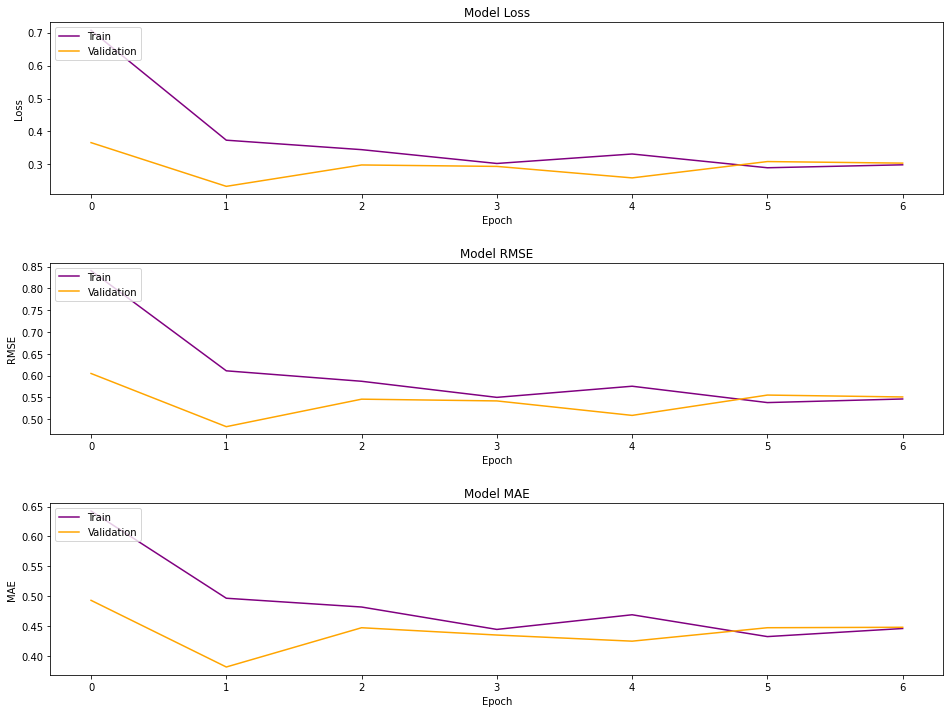

220601/220601 [==============================] - 3545s 16ms/step - loss: 0.2785 - root_mean_squared_error: 0.5277 - mean_absolute_error: 0.4256


In [ ]:
start = timeit.default_timer()
fit_model()
stop = timeit.default_timer()
train_time = stop - start


In [ ]:
print("LSTM Word Level Training Time: {} sec".format(round(train_time,2)))

LSTM Word Level Training Time: 4314.94 sec


In [ ]:
print("Eveluate Matrics:")
print("\tRMSE:",Eval_RMSE[0])
print("\tMAE:",Eval_MAE[0])
print("\tMSE(Loss):",Eval_Loss[0])

Eveluate Matrics:
	RMSE: 0.5277497172355652
	MAE: 0.4256249964237213
	MSE(Loss): 0.27851974964141846


### **Predict Test Set**

In [ ]:
model_t = get_full_model()
model_t.load_weights(os.path.join(Main_dir,'Siamese.h5'))

In [ ]:
test_gen = Embadding_Vectors_Generator(Embadding_size,w2v_model,train_df.iloc[:300],1,search_term_vec_size,prod_desc_vec_size,True)
for i in range(300):
    pred = model_t.predict(next(test_gen))
    print(pred)



In [ ]:
solutions_df = pd.read_csv(os.path.join(Main_dir,'solution.csv'), engine='python')
test_new = test_df.merge(solutions_df, on='id', how='left')[[ 'search_term', 'product_description','relevance']]

In [ ]:
test_new = test_new[test_new.relevance != -1]
test_new_y = test_new['relevance']
test_new.drop('relevance' , axis=1 , inplace=True)
len(test_new)

2021-01-23 10:00:17,131 : INFO : NumExpr defaulting to 2 threads.


112067

In [ ]:
start = timeit.default_timer()
test_generator = Embadding_Vectors_Generator(Embadding_size,w2v_model,test_new,1,search_term_vec_size,prod_desc_vec_size,True)
preds = model_t.predict_generator(test_generator)
stop = timeit.default_timer()
predict_time = stop - start
print("LSTM Word Level Predict Test Time: {} sec".format(round(predict_time,2)))

LSTM Word Level Predict Test Time: 2195.37 sec


In [ ]:
def round_pred_relevance(x):
    if x <= 0.5:
        return 0
    if x <= 1:
        return 1
    for i in range(1,3):
        if x <= i + 0.25:
            dif = ((i + 0.25)-x)
            if dif < 0.125:
                return i
            else:
                return i + 0.25
        if x <= i + 0.33:
            dif = ((i + 0.33)-x)
            if dif < 0.04:
                return i + 0.25
            else:
                return i + 0.33
        if x <= i + 0.5:
            dif = ((i + 0.5)-x)
            if dif < 0.085:
                return i + 0.33
            else:
                return i + 0.5
        if x <= i + 0.67:
            dif = ((i + 0.67)-x)
            if dif < 0.085:
                return i + 0.5
            else:
                return i + 0.67
        if x <= i + 0.75:
            dif = ((i + 0.75)-x)
            if dif < 0.04:
                return i + 0.67
            else:
                return i + 0.75
        if x <= i + 1:
            dif = ((i + 1)-x)
            if dif < 0.125:
                return i + 0.75
            else:
                return i + 1
    if x >= 3 and x <= 3.5:
        return 3
    else:
        return 4 

### **Visualiztion of the Results**

Because we are predicting the relevance, it is a regression problem, the output generated by our model will not be accurate to the defined relevance. It can be seen that the relevance rating we have in the Train Set is defined by numbers that are not necessarily integers, so to measure the quality of our model we will use a number of metrics as - **MSE, RMSE, MAE**, and to present a suitable visualization we will try to round as much as possible the predicted relevance to the appropriate relevance. We will try to find which rating this number is closest to and round it to it - using function **"round_pred_relevance"**

#### **Histogram of the relevance on Test Set**

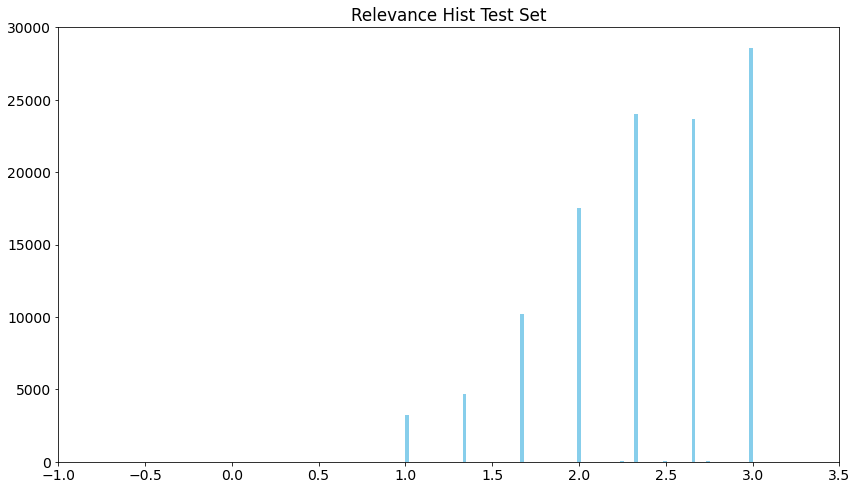

In [ ]:
plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(14,8)) 
plt.hist(test_new_y,bins="rice",color="skyblue",linewidth=3)
ax.set_title("Relevance Hist Test Set")
plt.xticks(np.arange(-1,4,0.5))

plt.show()

#### **Relevance Ratting**
**The Relevance is between 1 (not relevant) to 3 (highly relevant):**

The relevance can be on of these option - **[0, 1, 1.25, 1.33, 1.5, 1.67, 1.75, 2, 2.25, 2.33, 2.5, 2.67, 2.75, 3, 4].**

Records that have received relevance **-1** have been removed from the Test set because this relevance is not defined and we would like to avoid such deviations because our model does not learn at all this relevance.

In [ ]:
lbls_dict = {0: 'a' , 1: 'b' , 1.25: 'c' , 1.33: 'd' , 1.5: 'e' , 1.67 : 'f' , 1.75: 'g' ,
             2: 'h' , 2.25: 'i' , 2.33: 'j' , 2.5: 'k' , 2.67 : 'l' , 2.75: 'm' ,
             3: 'n' , 4:'o'}

In [ ]:
rounded_true = [lbls_dict[round_pred_relevance(x)] for x in test_new_y]
rounded_preds = [lbls_dict[round_pred_relevance(x)] for x in preds]

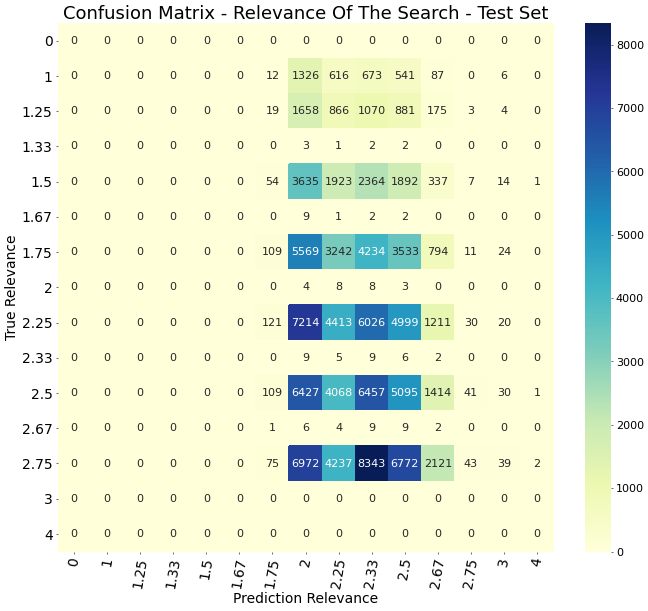

In [ ]:
fig, ax = plt.subplots(figsize=(16,14),dpi=50)
sns.heatmap(confusion_matrix(rounded_true,rounded_preds,list(lbls_dict.values())),cmap='YlGnBu',annot=True,fmt='g')
label_font = {'size':'20'} 
ax.set_xlabel('Prediction Relevance', fontdict=label_font)
ax.set_ylabel('True Relevance', fontdict=label_font)

title_font = {'size':'26'}
ax.set_title('Confusion Matrix - Relevance Of The Search - Test Set', fontdict=title_font)
ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_xticklabels(list(lbls_dict.keys()))
ax.set_yticklabels(list(lbls_dict.keys()))
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.show()

In [ ]:
new_preds = [round_pred_relevance(x) for x in preds]

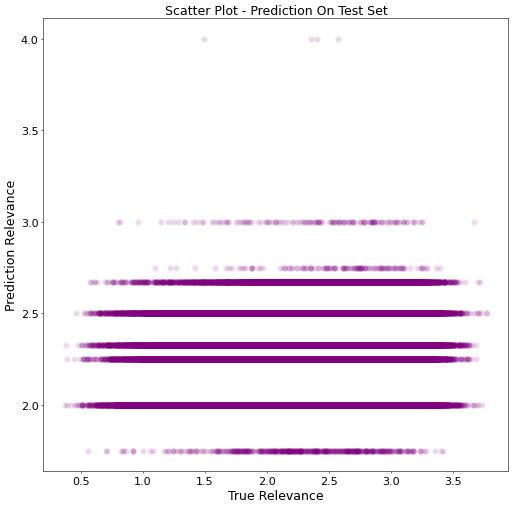

In [ ]:
fig , ax = plt.subplots(figsize=(12,12),dpi=50)
plt.scatter(test_new_y+np.random.normal(scale=0.2,size=preds.shape[0]),new_preds,alpha=0.1,c="purple",linewidths=3)
label_font = {'size':'18'} 
ax.set_xlabel('True Relevance', fontdict=label_font)
ax.set_ylabel('Prediction Relevance', fontdict=label_font)
title_font = {'size':'18'}
ax.set_title('Scatter Plot - Prediction On Test Set', fontdict=title_font)
plt.show()

**We can see that our model mainly predict relevance that is in the range of [2-3], which means it identifies a relatively high relevance for all the queries, it could be due to the size of vectors we set at the beginning of the task - 6 words in a query and 350 words in the product description, or maybe if we create more features it will help us to distinguish between queries that are not so relevance**

In [ ]:
mse = mean_squared_error(test_new_y, preds, squared=True)
rmse = mean_squared_error(test_new_y, preds, squared=False)
mae = mean_absolute_error(test_new_y, preds)

print("Matrics On Test Set")
print("\tMSE : ",mse)
print("\tRMSE : ",rmse)
print("\tMAE : ",mae)

Matrics On Test Set
	MSE :  0.2896154782597477
	RMSE :  0.5381593428156272
	MAE :  0.44780685230077844


## **Feature Extractor**

In this section we will use 2 main models for Features Extraction:
* **XGBoost**
* **Random forest**

We will first perform a prediction on the training set where the model we will use is the model we built except for the last layer - meaning the model output will be a vector of 128 size - i.e. 128 features for the Features Extraction models.

The prediction we performed on the training set will also be the training set for these 2 models and we will test their quality with the help of the test set - of course after performing a prediction with our model.

In [ ]:
model = get_full_model()
model.load_weights(os.path.join(Main_dir,'Siamese.h5'))
new_model = Model(model.input , model.layers[-2].output)
new_model.summary()
new_model.compile(loss='mse',optimizer='adam',metrics=[RootMeanSquaredError(), MeanAbsoluteError()])



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_1 (InputLayer)            [(None, 6, 352)]     0                                            
__________________________________________________________________________________________________
Input_2 (InputLayer)            [(None, 350, 352)]   0                                            
__________________________________________________________________________________________________
Siamese_Model (Functional)      (None, 128)          34592       Input_1[0][0]                    
                                                                 Input_2[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 128)          0           Siamese_Model[0][0]        

In [ ]:
train_generator = Embadding_Vectors_Generator(Embadding_size,w2v_model,train_df,1,search_term_vec_size,prod_desc_vec_size)
train_preds = new_model.predict_generator(train_generator)
true_Y = train_df['relevance']

In [ ]:
test_generator = Embadding_Vectors_Generator(Embadding_size,w2v_model,test_new,1,search_term_vec_size,prod_desc_vec_size,True)
preds_featres_extractor = new_model.predict_generator(test_generator)
test_Y = test_new['relevance']

In [ ]:
X = train_preds
Y = train_df['relevance']

### **XGBoost Model**

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [ ]:
start = timeit.default_timer()
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X,Y)
stop = timeit.default_timer()
total = stop - start
print("XGBoost Model as feature extractor with word level Training Time: {} Sec".format(round(total,2)))

[14:26:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Model as feature extractor with word level Training Time: 28.1 Sec


In [ ]:
start = timeit.default_timer()
y_pred = xgb_model.predict(preds_featres_extractor)
stop = timeit.default_timer()
total = stop - start
print("XGBoost Model as feature extractor with word level Predict Time: {} Sec".format(round(total,2)))

XGBoost Model as feature extractor with word level Predict Time: 0.73 Sec


In [ ]:
xgb_rounded_true = [lbls_dict[round_pred_relevance(x)] for x in test_Y]
xgb_rounded_preds = [lbls_dict[round_pred_relevance(x)] for x in y_pred]

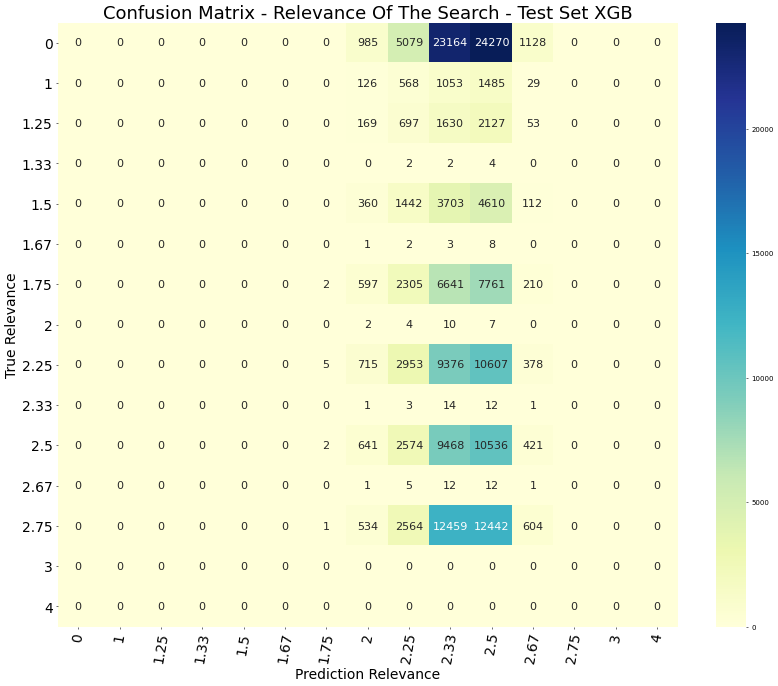

In [ ]:
fig, ax = plt.subplots(figsize=(20,16),dpi=50)
sns.heatmap(confusion_matrix(xgb_rounded_true,xgb_rounded_preds,list(lbls_dict.values())),cmap='YlGnBu',annot=True,fmt='g',annot_kws={"size": 16})
label_font = {'size':'20'} 
ax.set_xlabel('Prediction Relevance', fontdict=label_font)
ax.set_ylabel('True Relevance', fontdict=label_font)

title_font = {'size':'26'}
ax.set_title('Confusion Matrix - Relevance Of The Search - Test Set XGB', fontdict=title_font)
ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_xticklabels(list(lbls_dict.keys()))
ax.set_yticklabels(list(lbls_dict.keys()))
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.show()

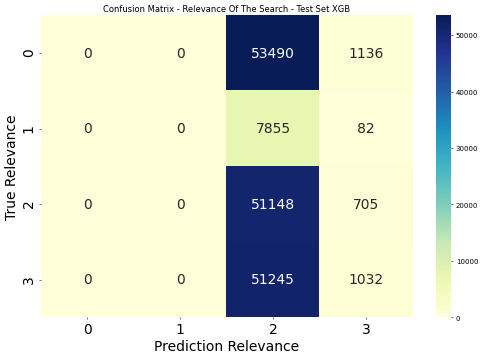

In [ ]:
fig, ax = plt.subplots(figsize=(12,8),dpi=50)
sns.heatmap(confusion_matrix(np.round(test_Y),np.round(y_pred)),cmap='YlGnBu',annot=True,fmt='.0f',annot_kws={"size": 20})
ax.set_title("Confusion Matrix - Relevance Of The Search - Test Set XGB")
label_font = {'size':'20'} 
ax.set_xlabel('Prediction Relevance', fontdict=label_font)
ax.set_ylabel('True Relevance', fontdict=label_font)
ax.tick_params(axis='both', which='major', labelsize=20) 
plt.show()

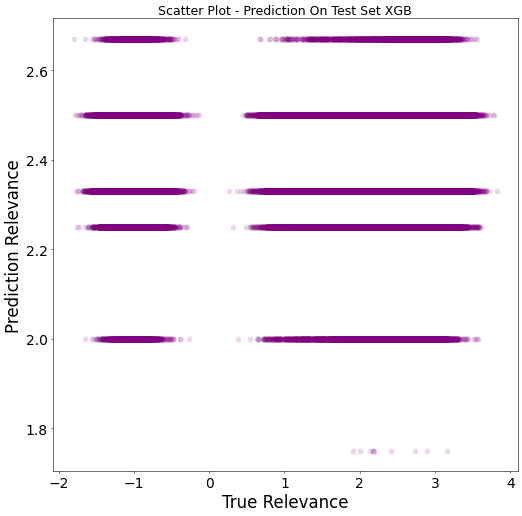

In [ ]:
new_preds = [round_pred_relevance(x) for x in y_pred]

fig , ax = plt.subplots(figsize=(12,12),dpi=50)
plt.scatter(test_Y+np.random.normal(scale=0.2,size=y_pred.shape[0]),new_preds,alpha=0.1,c="purple",linewidths=3)
label_font = {'size':'24'} 
ax.set_xlabel('True Relevance', fontdict=label_font)
ax.set_ylabel('Prediction Relevance', fontdict=label_font)
title_font = {'size':'18'}
ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_title('Scatter Plot - Prediction On Test Set XGB', fontdict=title_font)
plt.show()

**Here too it can be seen that the model predicts a relatively high relevance in the range of [2-2.67], but compared to our original model the values ​​received by the metrics are much higher**

In [ ]:
mse = mean_squared_error(test_Y, y_pred, squared=True)
rmse = mean_squared_error(test_Y, y_pred, squared=False)
mae = mean_absolute_error(test_Y, y_pred)

print("Matrics On Test Set")
print("\t\t MSE : ",mse)
print("\t\t RMSE : ",rmse)
print("\t\t MAE : ",mae)

Matrics On Test Set
		 MSE :  3.959590140282104
		 RMSE :  1.989871890419608
		 MAE :  1.4048712300109472


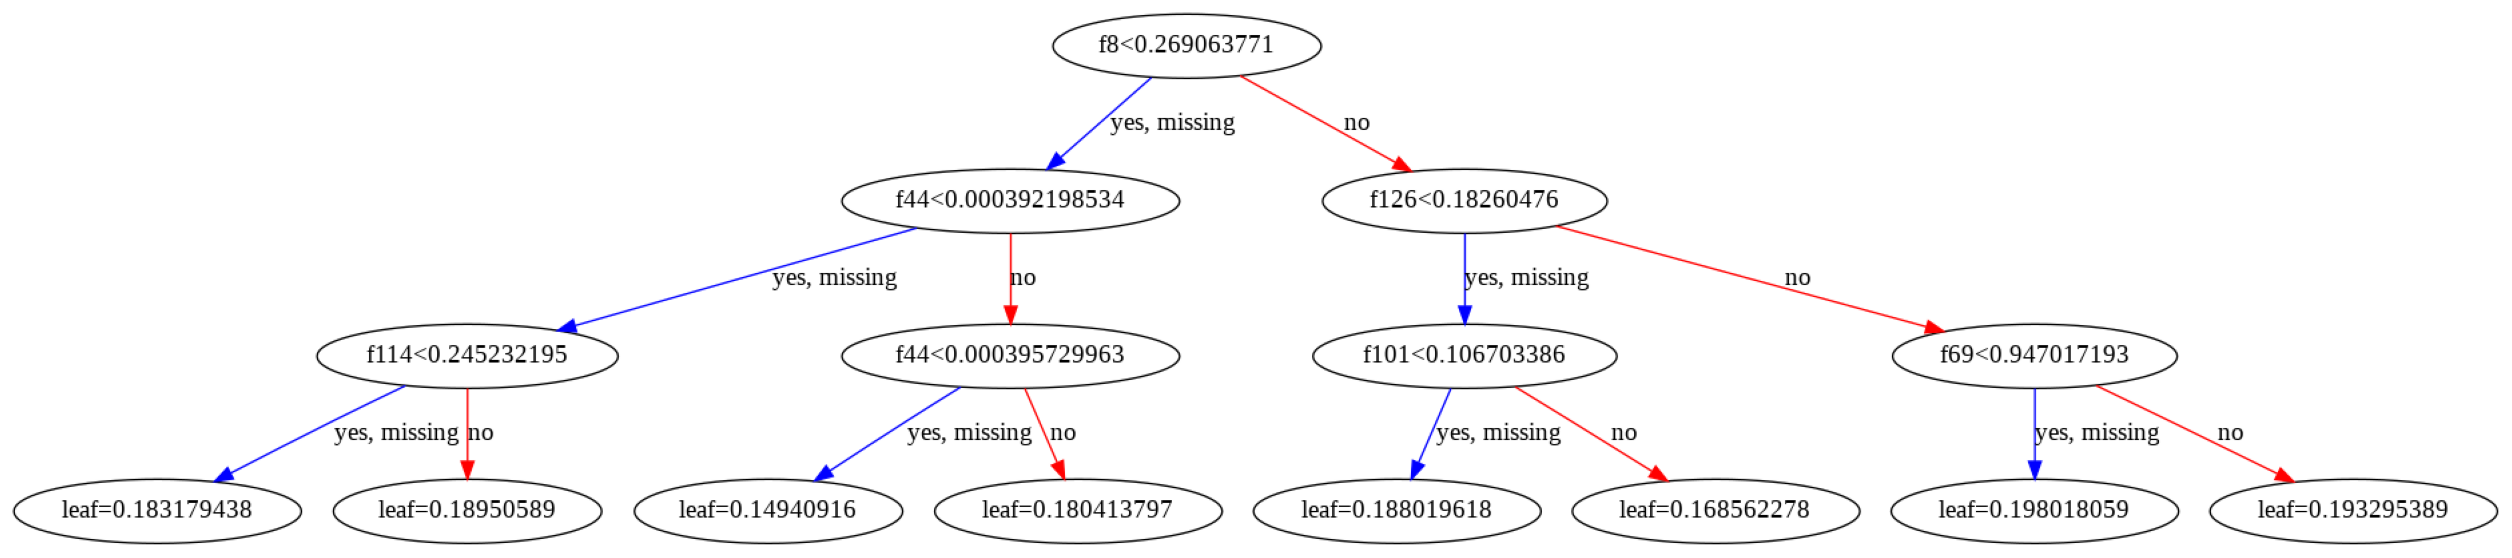

In [ ]:
xgb.plot_tree(xgb_model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

### **Random Forest**

In [ ]:
start = timeit.default_timer()
ranfom_forest_model = RandomForestRegressor(n_estimators = 100, random_state = 0) 
ranfom_forest_model.fit(X, Y) 
stop = timeit.default_timer()
total = stop - start
print("Random Forest Model as feature extractor with word level Training Time: {} Sec".format(round(total,2)))

Random Forest Model as feature extractor with word level Training Time: 262.41 Sec


In [ ]:
start = timeit.default_timer()
y_pred_rf = ranfom_forest_model.predict(preds_featres_extractor)
stop = timeit.default_timer()
total = stop - start
print("Random Forest Model as feature extractor with word level Predict Time: {} Sec".format(round(total,2)))

Random Forest Model as feature extractor with word level Predict Time: 4.5 Sec


In [ ]:
rf_rounded_true = [lbls_dict[round_pred_relevance(x)] for x in test_Y]
rf_rounded_preds = [lbls_dict[round_pred_relevance(x)] for x in y_pred_rf]

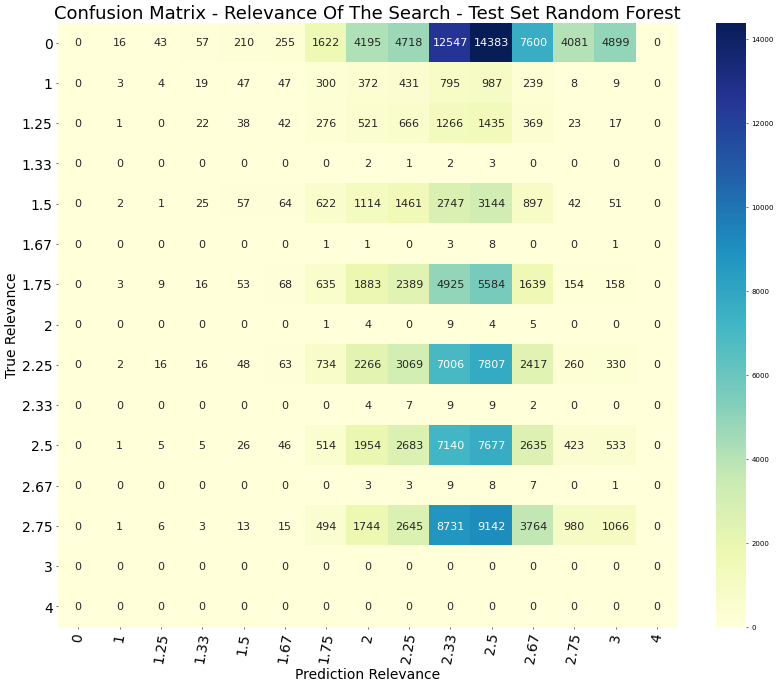

In [ ]:
fig, ax = plt.subplots(figsize=(20,16),dpi=50)
sns.heatmap(confusion_matrix(rf_rounded_true,rf_rounded_preds,list(lbls_dict.values())),cmap='YlGnBu',annot=True,fmt='g',annot_kws={"size": 16})
label_font = {'size':'20'} 
ax.set_xlabel('Prediction Relevance', fontdict=label_font)
ax.set_ylabel('True Relevance', fontdict=label_font)

title_font = {'size':'26'}
ax.set_title('Confusion Matrix - Relevance Of The Search - Test Set Random Forest', fontdict=title_font)
ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_xticklabels(list(lbls_dict.keys()))
ax.set_yticklabels(list(lbls_dict.keys()))
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.show()

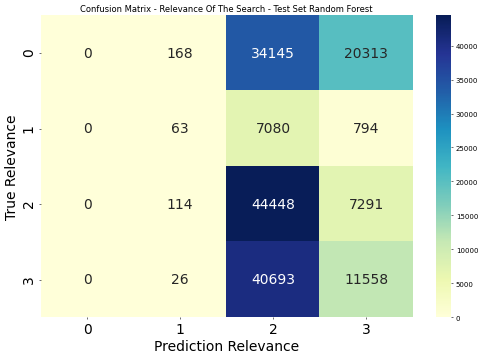

In [ ]:
fig, ax = plt.subplots(figsize=(12,8),dpi=50)
sns.heatmap(confusion_matrix(np.round(test_Y),np.round(y_pred_rf)),cmap='YlGnBu',annot=True,fmt='.0f',annot_kws={"size": 20})
ax.set_title("Confusion Matrix - Relevance Of The Search - Test Set Random Forest")
label_font = {'size':'20'} 
ax.set_xlabel('Prediction Relevance', fontdict=label_font)
ax.set_ylabel('True Relevance', fontdict=label_font)
ax.tick_params(axis='both', which='major', labelsize=20) 
#plt.figure(figsize=(16,16))
plt.show()

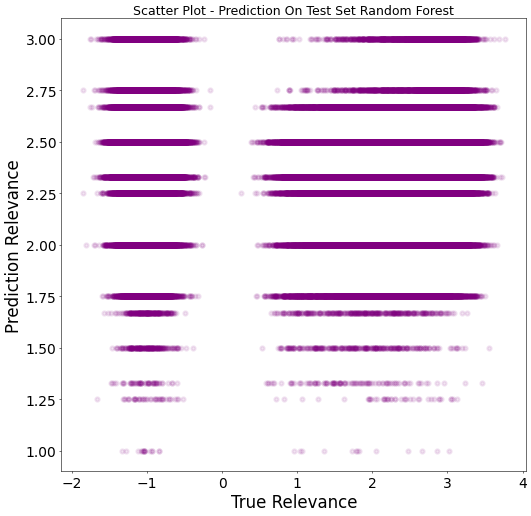

In [ ]:
new_preds = [round_pred_relevance(x) for x in y_pred_rf]

fig , ax = plt.subplots(figsize=(12,12),dpi=50)
plt.scatter(test_Y+np.random.normal(scale=0.2,size=y_pred_rf.shape[0]),new_preds,alpha=0.1,c="purple",linewidths=3)
label_font = {'size':'24'} 
ax.set_xlabel('True Relevance', fontdict=label_font)
ax.set_ylabel('Prediction Relevance', fontdict=label_font)
title_font = {'size':'18'}
ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_title('Scatter Plot - Prediction On Test Set Random Forest', fontdict=title_font)
plt.show()

**This model also predicts high relevance, but compared to the previous 2 models, many samples get even very high relevance between the ranges [2.67-3], and in addition there is a small tail of samples that get low relevance, which we did not see in the previous 2 models. **

**It seems that this model knows how to distinguish more between relevance but if we look at the Loss, it got the highest value.**

In [ ]:
mse = mean_squared_error(test_Y, y_pred_rf, squared=True)
rmse = mean_squared_error(test_Y, y_pred_rf, squared=False)
mae = mean_absolute_error(test_Y, y_pred_rf)

print("Matrics On Test Set")
print("\t\t MSE : ",mse)
print("\t\t RMSE : ",rmse)
print("\t\t MAE : ",mae)

Matrics On Test Set
		 MSE :  4.119039005340758
		 RMSE :  2.0295415751693184
		 MAE :  1.4210332237578693


## **Summary**

In [4]:
summariz_df = pd.DataFrame(columns=[ '' , 'Runtime (Sec)' , 'Train RMSE' , 'Val-RMSE' , 'Test-RMSE' , 'Train MAE' , 'Val-MAE' , 'Test-MAE'])
summariz_df[''] = ['Naïve Benchmark model - Random Forest generator' , 'Naïve Benchmark model - XGBRegressor' ,
                   'LSTM with Character level input' , 'LSTM as feature extractor with Character level input- Random Forest','LSTM as feature extractor with Character level input- XGBoost',
                   'LSTM with Word level input' , 'LSTM as feature extractor with Word level input- Random Forest','LSTM as feature extractor with Word level input- XGBoost']
summariz_df.set_index('' , inplace=True)

summariz_df.loc['Naïve Benchmark model - Random Forest generator' , 'Runtime (Sec)'] = 1.024
summariz_df.loc['Naïve Benchmark model - Random Forest generator' , 'Train RMSE'] = 0.526
summariz_df.loc['Naïve Benchmark model - Random Forest generator', 'Val-RMSE'] =  0.5248
summariz_df.loc['Naïve Benchmark model - Random Forest generator' , 'Test-RMSE'] = 0.5282
summariz_df.loc['Naïve Benchmark model - Random Forest generator' , 'Train MAE'] =0.4289
summariz_df.loc['Naïve Benchmark model - Random Forest generator' , 'Val-MAE'] =0.4271
summariz_df.loc['Naïve Benchmark model - Random Forest generator' , 'Test-MAE'] = 0.43

summariz_df.loc['Naïve Benchmark model - XGBRegressor' , 'Runtime (Sec)'] =26.78
summariz_df.loc['Naïve Benchmark model - XGBRegressor' , 'Train RMSE'] =  0.4892064916455119
summariz_df.loc['Naïve Benchmark model - XGBRegressor', 'Val-RMSE'] =  0.509
summariz_df.loc['Naïve Benchmark model - XGBRegressor' , 'Test-RMSE'] = 0.5219
summariz_df.loc['Naïve Benchmark model - XGBRegressor' , 'Train MAE'] =  0.4
summariz_df.loc['Naïve Benchmark model - XGBRegressor' , 'Val-MAE'] =  0.4167
summariz_df.loc['Naïve Benchmark model - XGBRegressor' , 'Test-MAE'] = 0.4269

summariz_df.loc['LSTM with Character level input' , 'Runtime (Sec)'] = 79.78
summariz_df.loc['LSTM with Character level input' , 'Train RMSE'] = 0.5260
summariz_df.loc['LSTM with Character level input', 'Val-RMSE'] = 0.5262
summariz_df.loc['LSTM with Character level input' , 'Test-RMSE'] =  0.5356
summariz_df.loc['LSTM with Character level input' , 'Train MAE'] =  0.43 
summariz_df.loc['LSTM with Character level input' , 'Val-MAE'] =0.4257
summariz_df.loc['LSTM with Character level input' , 'Test-MAE'] = 0.4324

summariz_df.loc['LSTM as feature extractor with Character level input- Random Forest' , 'Runtime (Sec)'] = 1.411
summariz_df.loc['LSTM as feature extractor with Character level input- Random Forest' , 'Train RMSE'] = 0.5259
summariz_df.loc['LSTM as feature extractor with Character level input- Random Forest', 'Val-RMSE'] = 0.5258
summariz_df.loc['LSTM as feature extractor with Character level input- Random Forest' , 'Test-RMSE'] = 0.53
summariz_df.loc['LSTM as feature extractor with Character level input- Random Forest' , 'Train MAE'] = 0.4293
summariz_df.loc['LSTM as feature extractor with Character level input- Random Forest' , 'Val-MAE'] = 0.4288
summariz_df.loc['LSTM as feature extractor with Character level input- Random Forest' , 'Test-MAE'] = 0.4333

summariz_df.loc['LSTM as feature extractor with Character level input- XGBoost' , 'Runtime (Sec)'] =33.371
summariz_df.loc['LSTM as feature extractor with Character level input- XGBoost' , 'Train RMSE'] = 0.49
summariz_df.loc['LSTM as feature extractor with Character level input- XGBoost', 'Val-RMSE'] =  0.5158
summariz_df.loc['LSTM as feature extractor with Character level input- XGBoost' , 'Test-RMSE'] =0.53
summariz_df.loc['LSTM as feature extractor with Character level input- XGBoost' , 'Train MAE'] =0.4
summariz_df.loc['LSTM as feature extractor with Character level input- XGBoost' , 'Val-MAE'] = 0.4212
summariz_df.loc['LSTM as feature extractor with Character level input- XGBoost' , 'Test-MAE'] =0.4212

summariz_df.loc['LSTM with Word level input' , 'Runtime (Sec)'] = 6510.31
summariz_df.loc['LSTM with Word level input' , 'Train RMSE'] = 0.5763
summariz_df.loc['LSTM with Word level input', 'Val-RMSE'] = 0.52774
summariz_df.loc['LSTM with Word level input' , 'Test-RMSE'] =  0.5381
summariz_df.loc['LSTM with Word level input' , 'Train MAE'] =  0.4733 
summariz_df.loc['LSTM with Word level input' , 'Val-MAE'] = 0.42562
summariz_df.loc['LSTM with Word level input' , 'Test-MAE'] = 0.4478

summariz_df.loc['LSTM as feature extractor with Word level input- Random Forest' , 'Runtime (Sec)'] = 266.91 
summariz_df.loc['LSTM as feature extractor with Word level input- Random Forest' , 'Train RMSE'] = 0
summariz_df.loc['LSTM as feature extractor with Word level input- Random Forest', 'Val-RMSE'] = 0
summariz_df.loc['LSTM as feature extractor with Word level input- Random Forest' , 'Test-RMSE'] = 2.0295
summariz_df.loc['LSTM as feature extractor with Word level input- Random Forest' , 'Train MAE'] = 0
summariz_df.loc['LSTM as feature extractor with Word level input- Random Forest' , 'Val-MAE'] = 0
summariz_df.loc['LSTM as feature extractor with Word level input- Random Forest' , 'Test-MAE'] = 1.4210

summariz_df.loc['LSTM as feature extractor with Word level input- XGBoost' , 'Runtime (Sec)'] = 28.83 
summariz_df.loc['LSTM as feature extractor with Word level input- XGBoost' , 'Train RMSE'] = 0
summariz_df.loc['LSTM as feature extractor with Word level input- XGBoost', 'Val-RMSE'] =  0
summariz_df.loc['LSTM as feature extractor with Word level input- XGBoost' , 'Test-RMSE'] = 1.9898
summariz_df.loc['LSTM as feature extractor with Word level input- XGBoost' , 'Train MAE'] = 0
summariz_df.loc['LSTM as feature extractor with Word level input- XGBoost' , 'Val-MAE'] = 0
summariz_df.loc['LSTM as feature extractor with Word level input- XGBoost' , 'Test-MAE'] = 1.4048

summariz_df


,Runtime (Sec),Train RMSE,Val-RMSE,Test-RMSE,Train MAE,Val-MAE,Test-MAE
,,,,,,,
Naïve Benchmark model - Random Forest generator,1.024,0.526,0.5248,0.5282,0.4289,0.4271,0.43
Naïve Benchmark model - XGBRegressor,26.78,0.489206,0.509,0.5219,0.4,0.4167,0.4269
LSTM with Character level input,79.78,0.526,0.5262,0.5356,0.43,0.4257,0.4324
LSTM as feature extractor with Character level input- Random Forest,1.411,0.5259,0.5258,0.53,0.4293,0.4288,0.4333
LSTM as feature extractor with Character level input- XGBoost,33.371,0.49,0.5158,0.53,0.4,0.4212,0.4212
LSTM with Word level input,6510.31,0.5763,0.52774,0.5381,0.4733,0.42562,0.4478
LSTM as feature extractor with Word level input- Random Forest,266.91,0,0,2.0295,0,0,1.421
LSTM as feature extractor with Word level input- XGBoost,28.83,0,0,1.9898,0,0,1.4048


In [5]:
summariz_df.to_csv(r'/content/sample_data/res.csv')